In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from functools import partial
import pyDOE
from sklearn.gaussian_process.kernels import Matern

from robustGP.SURmodel import AdaptiveStrategy
from robustGP.test_functions import branin_2d
import robustGP.tools as tools
import robustGP.gptools
import robustGP.acquisition.acquisition as ac
import robustGP.enrichment.Enrichment as enrich
import robustGP.optimisers as opt


In [30]:

plt.style.use("seaborn")
plt.rc("text.latex", preamble=r"\usepackage{amsmath} \usepackage{amssymb}")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"],
    'image.cmap': u'viridis',
    'figure.figsize': [8, 8],
    'savefig.dpi': 200
})

In [31]:
def initialize_branin(initial_design=None):
    """
    Create new instance of AdaptiveStrategy of the Branin 2d function
    with LHS as initial design
    """
    NDIM = 2
    if initial_design is None:
        initial_design = 5 * NDIM
    bounds = np.asarray([(0, 1)] * NDIM)
    initial_design = pyDOE.lhs(
        n=NDIM, samples=initial_design, criterion="maximin", iterations=50
    )
    branin = AdaptiveStrategy(bounds, branin_2d)
    branin.fit_gp(
        initial_design,
        branin.evaluate_function(initial_design),
        Matern(np.ones(NDIM)),
        n_restarts_optimizer=50,
    )
    branin.set_idxU([1], ndim=2)
    return branin


bounds = np.asarray([[0, 1], [0, 1]])
# For plots
x, y = np.linspace(0, 1, 50), np.linspace(0, 1, 50)
(XY, (xmg, ymg)) = tools.pairify((x, y))
xl, yl = np.linspace(0, 1, 500), np.linspace(0, 1, 500)
(XYl, (xmgl, ymgl)) = tools.pairify((xl, yl))

In [32]:
branin = initialize_branin()

In [33]:
maximum_variance = enrich.OneStepEnrichment(bounds)
maximum_variance.set_optim(opt.optimize_with_restart, **{"bounds": bounds, "nrestart": 20})

def variance(arg, X):
    return arg.predict(X, return_std=True)[1] ** 2

maximum_variance.set_criterion(variance, maxi=True)
branin.set_enrichment(maximum_variance)
branin.run(Niter=100)

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Text(0.5, 1.0, '$J - m_Z$')

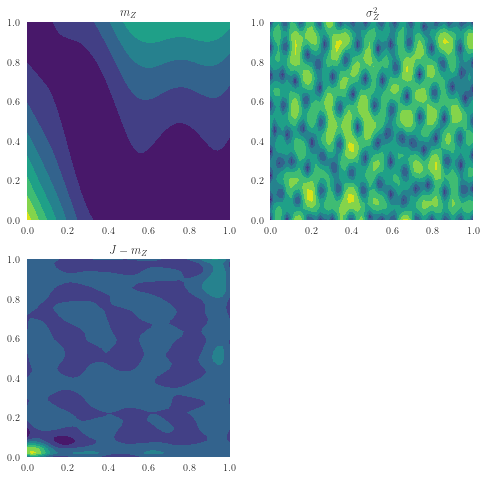

In [34]:
m, s = branin.predict(XY, return_std=True)
plt.subplot(2, 2, 1)
plt.contourf(x, y, m.reshape(50, 50).T)
plt.title(r"$m_Z$")
plt.subplot(2, 2, 2)
plt.contourf(x, y, s.reshape(50, 50).T)
plt.title(r"$\sigma^2_Z$")
plt.subplot(2, 2, 3)
plt.contourf(x, y, (m.reshape(50, 50) - branin.function(XY).reshape(50, 50)))
plt.title(r"$J - m_Z$")

In [20]:
plt.show()